HW4-1

Episode 50, Reward: -14, Epsilon: 0.778
Episode 100, Reward: -11, Epsilon: 0.606
Episode 150, Reward: -6, Epsilon: 0.471
Episode 200, Reward: 1, Epsilon: 0.367
Episode 250, Reward: -14, Epsilon: 0.286
Episode 300, Reward: 1, Epsilon: 0.222
Episode 350, Reward: 2, Epsilon: 0.173
Episode 400, Reward: 4, Epsilon: 0.135
Episode 450, Reward: 4, Epsilon: 0.105
Episode 500, Reward: 3, Epsilon: 0.100


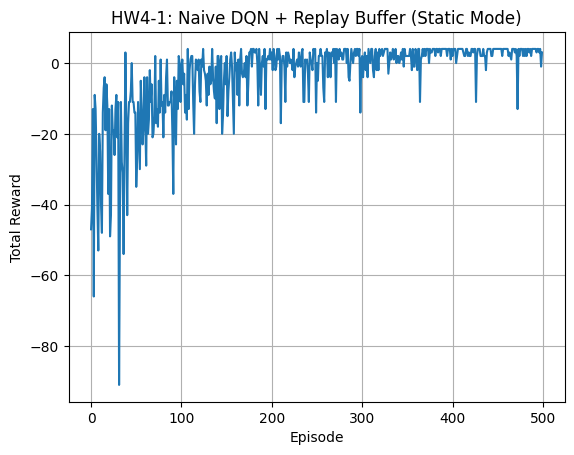

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
from Gridworld import Gridworld
import random

# 建立 Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = []
        self.capacity = capacity
        self.index = 0

    def push(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        if len(self.buffer) < self.capacity:
            self.buffer.append(data)
        else:
            self.buffer[self.index] = data
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)
        return (
            torch.stack(states),
            torch.tensor(actions),
            torch.tensor(rewards),
            torch.stack(next_states),
            torch.tensor(dones)
        )

    def __len__(self):
        return len(self.buffer)

# One-hot 狀態轉換
def get_state(env):
    board = env.board.render_np().astype(np.float32)
    return torch.from_numpy(board).view(-1)

# Q-Network 定義
class QNet(nn.Module):
    def __init__(self, input_size=64, hidden_size=128, output_size=4):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

# 動作集合
actions = ['u', 'd', 'l', 'r']

# 超參數
EPISODES = 500
GAMMA = 0.9
LR = 0.01
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 0.995
BATCH_SIZE = 32
REPLAY_WARMUP = 100

def train():
    qnet = QNet()
    optimizer = optim.Adam(qnet.parameters(), lr=LR)
    epsilon = EPSILON_START
    buffer = ReplayBuffer()
    reward_log = []

    os.makedirs("docs", exist_ok=True)

    for ep in range(EPISODES):
        env = Gridworld(size=4, mode='static')
        state = get_state(env)
        total_reward = 0
        done = False

        while not done:
            if np.random.rand() < epsilon:
                action_idx = np.random.randint(0, 4)
            else:
                with torch.no_grad():
                    q_values = qnet(state)
                    action_idx = torch.argmax(q_values).item()

            env.makeMove(actions[action_idx])
            reward = env.reward()
            next_state = get_state(env)
            done_flag = reward in [10, -10]

            buffer.push(state, action_idx, reward, next_state, done_flag)

            # ✅ 訓練操作放在 if 裡面
            if len(buffer) >= REPLAY_WARMUP:
                states, actions_, rewards, next_states, dones = buffer.sample(BATCH_SIZE)

                q_pred = qnet(states).gather(1, actions_.unsqueeze(1)).squeeze()
                with torch.no_grad():
                    q_target = rewards + GAMMA * qnet(next_states).max(1)[0] * (1 - dones.float())

                loss = (q_pred - q_target).pow(2).mean()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            state = next_state
            total_reward += reward
            if done_flag:
                break

        reward_log.append(total_reward)
        epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

        if (ep + 1) % 50 == 0:
            print(f"Episode {ep+1}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")

    # 畫圖
    plt.plot(reward_log)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('HW4-1: Naive DQN + Replay Buffer (Static Mode)')
    plt.grid()
    plt.savefig('docs/hw4_1_reward.png')
    plt.show()

if __name__ == "__main__":
    train()


HW4-2 Double DQN

Episode 50, Reward: -10, Epsilon: 0.778
Episode 100, Reward: 0, Epsilon: 0.606
Episode 150, Reward: 9, Epsilon: 0.471
Episode 200, Reward: 6, Epsilon: 0.367
Episode 250, Reward: 5, Epsilon: 0.286
Episode 300, Reward: 3, Epsilon: 0.222
Episode 350, Reward: 3, Epsilon: 0.173
Episode 400, Reward: 6, Epsilon: 0.135
Episode 450, Reward: 6, Epsilon: 0.105
Episode 500, Reward: 1, Epsilon: 0.100


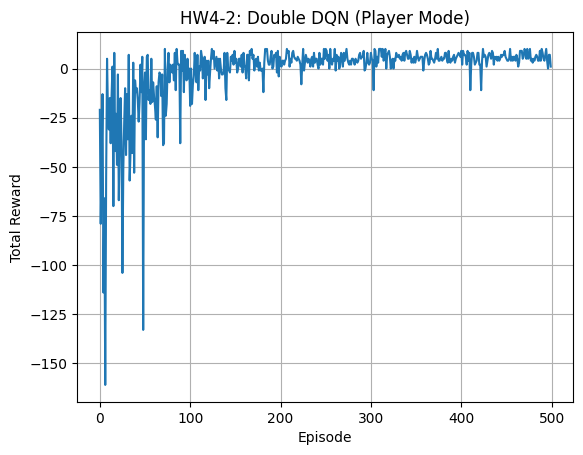

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from Gridworld import Gridworld
import copy
import os

os.makedirs("docs", exist_ok=True)

# 取得 one-hot 狀態向量
def get_state(env):
    board = env.board.render_np().astype(np.float32)
    return torch.from_numpy(board).view(-1)

# Q-Network 定義
class QNet(nn.Module):
    def __init__(self, input_size=64, hidden_size=128, output_size=4):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

# 動作定義
actions = ['u', 'd', 'l', 'r']

# 超參數
EPISODES = 500
GAMMA = 0.9
LR = 0.01
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 0.995
TARGET_UPDATE_FREQ = 10

def train():
    qnet = QNet()
    target_net = copy.deepcopy(qnet)
    optimizer = optim.Adam(qnet.parameters(), lr=LR)
    epsilon = EPSILON_START
    reward_log = []

    for ep in range(EPISODES):
        env = Gridworld(size=4, mode='player')
        state = get_state(env)
        done = False
        ep_reward = 0

        while not done:
            # ε-greedy 選動作
            if np.random.rand() < epsilon:
                action_idx = np.random.randint(0, 4)
            else:
                with torch.no_grad():
                    q_values = qnet(state)
                    action_idx = torch.argmax(q_values).item()

            env.makeMove(actions[action_idx])
            reward = env.reward()
            next_state = get_state(env)

            with torch.no_grad():
                # Double DQN target 計算
                best_action = torch.argmax(qnet(next_state)).item()
                target = reward + GAMMA * target_net(next_state)[best_action]

            pred = qnet(state)[action_idx]
            loss = (pred - target).pow(2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state
            ep_reward += reward
            if reward in [10, -10]:
                done = True

        reward_log.append(ep_reward)
        epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

        # 更新 target network
        if (ep + 1) % TARGET_UPDATE_FREQ == 0:
            target_net.load_state_dict(qnet.state_dict())

        if (ep + 1) % 50 == 0:
            print(f"Episode {ep+1}, Reward: {ep_reward}, Epsilon: {epsilon:.3f}")

    # 畫圖
    plt.plot(reward_log)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('HW4-2: Double DQN (Player Mode)')
    plt.grid()
    plt.savefig('docs/hw4_2_double.png')
    plt.show()

if __name__ == "__main__":
    train()

HW4-2 Dueling DQN

Episode 50, Reward: 3, Epsilon: 0.778
Episode 100, Reward: 6, Epsilon: 0.606
Episode 150, Reward: 4, Epsilon: 0.471
Episode 200, Reward: 2, Epsilon: 0.367
Episode 250, Reward: 5, Epsilon: 0.286
Episode 300, Reward: 4, Epsilon: 0.222
Episode 350, Reward: 5, Epsilon: 0.173
Episode 400, Reward: 5, Epsilon: 0.135
Episode 450, Reward: 5, Epsilon: 0.105
Episode 500, Reward: 4, Epsilon: 0.100


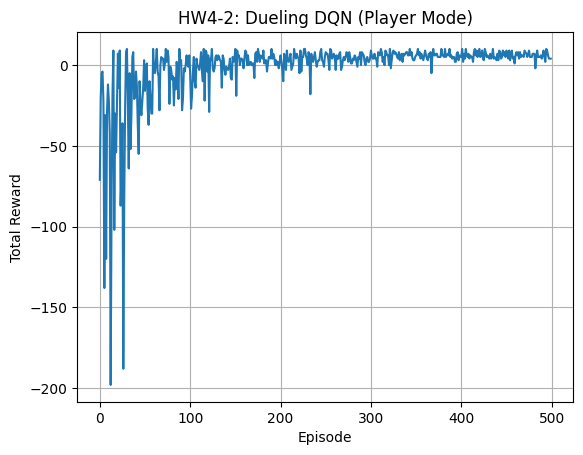

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from Gridworld import Gridworld
import os

os.makedirs("docs", exist_ok=True)

# 將環境轉換成 one-hot 狀態向量
def get_state(env):
    board = env.board.render_np().astype(np.float32)
    return torch.from_numpy(board).view(-1)

# Dueling Q-Network 架構
class DuelingQNet(nn.Module):
    def __init__(self, input_size=64, hidden_size=128, output_size=4):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()

        self.fc_value = nn.Linear(hidden_size, 1)       # V(s)
        self.fc_advantage = nn.Linear(hidden_size, output_size)  # A(s,a)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        value = self.fc_value(x)
        advantage = self.fc_advantage(x)
        q = value + (advantage - advantage.mean())
        return q

# 動作集合
actions = ['u', 'd', 'l', 'r']

# 超參數
EPISODES = 500
GAMMA = 0.9
LR = 0.01
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 0.995

def train():
    qnet = DuelingQNet()
    optimizer = optim.Adam(qnet.parameters(), lr=LR)
    epsilon = EPSILON_START
    reward_log = []

    for ep in range(EPISODES):
        env = Gridworld(size=4, mode='player')
        state = get_state(env)
        done = False
        ep_reward = 0

        while not done:
            # ε-greedy 策略
            if np.random.rand() < epsilon:
                action_idx = np.random.randint(0, 4)
            else:
                with torch.no_grad():
                    q_values = qnet(state)
                    action_idx = torch.argmax(q_values).item()

            env.makeMove(actions[action_idx])
            reward = env.reward()
            next_state = get_state(env)

            with torch.no_grad():
                target = reward + GAMMA * torch.max(qnet(next_state))

            pred = qnet(state)[action_idx]
            loss = (pred - target).pow(2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state
            ep_reward += reward
            if reward in [10, -10]:
                done = True

        reward_log.append(ep_reward)
        epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

        if (ep + 1) % 50 == 0:
            print(f"Episode {ep+1}, Reward: {ep_reward}, Epsilon: {epsilon:.3f}")

    # 繪製 reward 曲線
    plt.plot(reward_log)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('HW4-2: Dueling DQN (Player Mode)')
    plt.grid()
    plt.savefig('docs/hw4_2_dueling.png')
    plt.show()

if __name__ == "__main__":
    train()

HW4-3

c:\Users\jing5\anaconda3\envs\RL\lib\site-packages\pytorch_lightning\core\module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


Episode 50, Reward: 9.5, ε=0.837
Episode 100, Reward: 7.5, ε=0.670
Episode 150, Reward: 10.0, ε=0.503
Episode 200, Reward: -35.0, ε=0.337
Episode 250, Reward: -42.0, ε=0.170
Episode 300, Reward: 8.5, ε=0.100
Episode 350, Reward: -100.0, ε=0.100
Episode 400, Reward: 0.5, ε=0.100
Episode 450, Reward: 8.5, ε=0.100
Episode 500, Reward: -14.5, ε=0.100


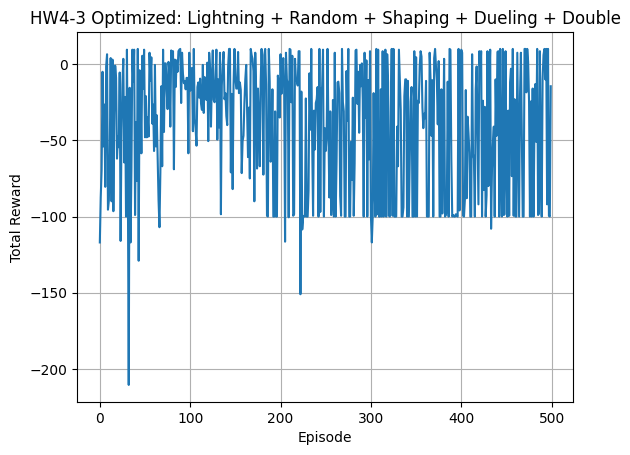

In [4]:
import torch
import matplotlib.pyplot as plt
from Gridworld import Gridworld
from models import DQNLightningModule
import pytorch_lightning as pl
import os

os.makedirs("docs", exist_ok=True)

def get_state(env):
    board = env.board.render_np().astype(float)
    return torch.tensor(board).view(-1)

def compute_shaped_reward(env, reward):
    # reward shaping：靠近 Goal 給額外 0.5
    player = env.board.components['Player'].pos
    goal = env.board.components['Goal'].pos
    manhattan = abs(player[0] - goal[0]) + abs(player[1] - goal[1])
    shaping = max(0, 2 - manhattan) * 0.5  # 最多 +1
    return reward + shaping

# 設定
EPISODES = 500
BATCH_SIZE = 64
REPLAY_WARMUP = 200
TRAIN_EVERY = 5
MAX_STEPS = 100

def train_hw4_3():
    model = DQNLightningModule(batch_size=BATCH_SIZE, double_dqn=True)
    optimizer, _ = model.configure_optimizers()
    optimizer = optimizer[0]
    reward_log = []

    for ep in range(EPISODES):
        # 前 100 集先 player 模式（較簡單），後面才 random
        mode = 'player' if ep < 100 else 'random'
        env = Gridworld(size=4, mode=mode)
        state = get_state(env).float()
        total_reward = 0
        steps = 0
        done = False

        while not done and steps < MAX_STEPS:
            epsilon = max(0.1, 1.0 - ep / 300)
            if torch.rand(1).item() < epsilon:
                action_idx = torch.randint(0, 4, (1,)).item()
            else:
                with torch.no_grad():
                    q = model(state.unsqueeze(0))
                    action_idx = torch.argmax(q).item()

            env.makeMove(['u', 'd', 'l', 'r'][action_idx])
            reward = env.reward()
            reward = compute_shaped_reward(env, reward)  # ✅ Reward Shaping
            reward = max(-10, min(reward, 10))  # ✅ 防止爆炸

            next_state = get_state(env).float()
            done_flag = reward >= 10 or reward <= -10

            model.buffer.push(
                state,
                torch.tensor(action_idx, dtype=torch.long),
                torch.tensor(reward, dtype=torch.float32),
                next_state,
                torch.tensor(done_flag, dtype=torch.float32)
            )

            if len(model.buffer) > REPLAY_WARMUP and ep % TRAIN_EVERY == 0:
                batch = model.sample_batch()
                if batch:
                    loss = model.training_step(batch, 0)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.q_net.parameters(), max_norm=1.0)
                    optimizer.step()
                    optimizer.zero_grad()

            state = next_state
            total_reward += reward
            steps += 1
            if done_flag:
                break

        reward_log.append(total_reward)
        if (ep + 1) % 50 == 0:
            print(f"Episode {ep+1}, Reward: {total_reward:.1f}, ε={epsilon:.3f}")

    plt.plot(reward_log)
    plt.title("HW4-3 Optimized: Lightning + Random + Shaping + Dueling + Double")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid()
    plt.savefig("docs/hw4_3_optimized.png")
    plt.show()

if __name__ == "__main__":
    train_hw4_3()
